# iSoftStone Information Technology (Group) Co., Ltd. Stock Analysis 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import warnings
from scipy.stats import ks_2samp
from scipy.stats import skew, kurtosis


In [2]:
p = 10000   # number of paths generated testing set   
p_t = 10000

In [3]:
df = pd.read_csv("C:/Users/19874/OneDrive/桌面/软通动力/软通动力股价分析.csv")
df.dropna(inplace=True)
print(df.isna().sum())  # Count NaN values per column

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


0      29.47
1      27.97
2      26.83
3      27.05
4      26.17
       ...  
482    54.80
483    56.21
484    53.68
485    60.10
486    65.10
Name: Close, Length: 485, dtype: float64


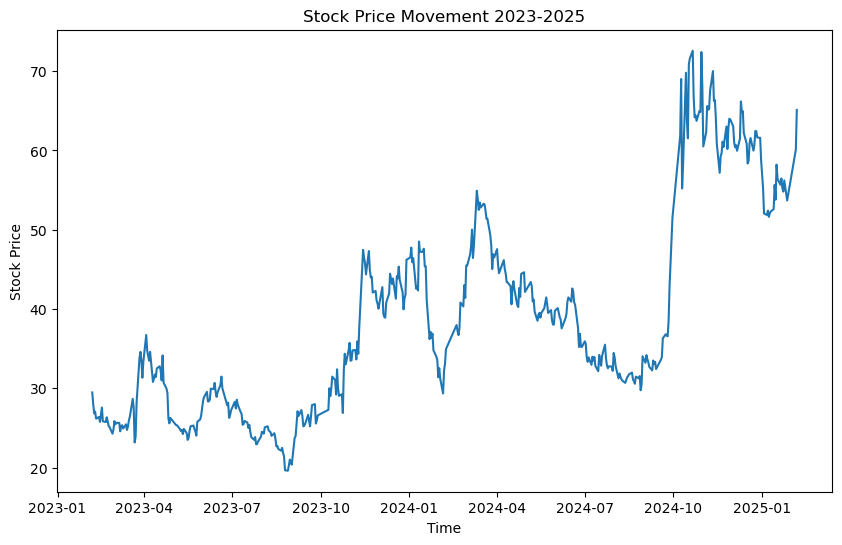

In [4]:
print(df['Close'])
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(10, 6))
plt.plot(df['Date'],df['Close'])
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Movement 2023-2025")
plt.show()

In [5]:
df["shifted_price"] = df["Close"].shift(-1)
print(df["shifted_price"])

0      27.97
1      26.83
2      27.05
3      26.17
4      26.38
       ...  
482    56.21
483    53.68
484    60.10
485    65.10
486      NaN
Name: shifted_price, Length: 485, dtype: float64


In [6]:
df['daily_return'] = (df["shifted_price"]-df["Close"])/df["Close"]
df.loc[0:248,'daily_return'].describe()

count    248.000000
mean       0.001597
std        0.050422
min       -0.158373
25%       -0.027617
50%        0.000305
75%        0.026347
max        0.200149
Name: daily_return, dtype: float64

C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


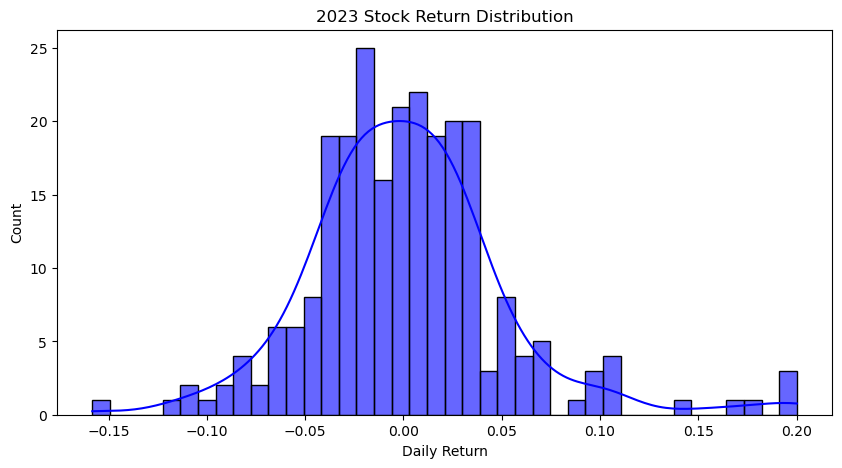

In [7]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop or fill NaN values
df.dropna(inplace=True)  # Drop rows with NaN
# df.fillna(0, inplace=True)  # Alternatively, fill NaNs with 0


plt.figure(figsize=(10, 5))
sns.histplot(df.loc[0:248,'daily_return'], bins = 40, kde=True, color="blue", alpha=0.6)
plt.title("2023 Stock Return Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Count")
plt.show()

In [8]:
print(df['Close'][248])

29.34


In [9]:
trading_time_total_unit_2023 = df.loc[0:248, 'Close'].count()
daily_drift_2023 = np.log(df.loc[0:248,'daily_return']+1).sum() / trading_time_total_unit_2023
total_drift_2023 = daily_drift_2023 * trading_time_total_unit_2023
daily_vol_2023 = (((np.log(df.loc[0:248,'daily_return']+1) - daily_drift_2023)**2).sum() / (trading_time_total_unit_2023-1)) ** 0.5
total_vol_2023 = daily_vol_2023 * ((trading_time_total_unit_2023) ** 0.5)
print(trading_time_total_unit_2023, total_drift_2023,total_vol_2023)

248 0.09014524649217742 0.7794920087968787


# Jump Diffusion GBM Simulation after 02/06/2024 based on 2023 data

In [10]:
trading_time_total_unit_2024 = df.loc[249::, 'Close'].count()
T = 1   # Total time interval
n = trading_time_total_unit_2024 # Gap Count
constant_time_gap = T/n
t = np.linspace(0,T,n)
B0 = 0       # Initial BM point

In [11]:
log_returns = np.log(df.loc[0:248, 'Close']/ df.loc[0:248, 'Close'].shift(1)).dropna()
mu_r = np.mean(log_returns)
sigma_r = np.std(log_returns)

# Define threshold for jumps (3 standard deviations from mean)
threshold = mu_r + 3 * sigma_r

# Count jump occurrences
jump_days = np.sum((log_returns > threshold) | (log_returns < -threshold))

num_years = len(log_returns) / (trading_time_total_unit_2023-1)  #-1 because of the shifting difference and drop NA
lambda_estimate_2023 = jump_days / num_years 
print(num_years)
print(f"Estimated Jump Intensity (lambda): {lambda_estimate_2023:.2f} jumps per year in 2023")

1.0
Estimated Jump Intensity (lambda): 6.00 jumps per year in 2023


In [12]:
jump_returns = log_returns[(log_returns > threshold) | (log_returns < -threshold)]
mu_J_estimate = np.mean(jump_returns)
sigma_J_estimate = np.std(jump_returns)
print("Jump Returns:", jump_returns)
print(f"Estimated Mean Jump Size (mu_J): {mu_J_estimate:.4f}")
print(f"Estimated Jump Volatility (sigma_J): {sigma_J_estimate:.4f}")

Jump Returns: 32    -0.172418
34     0.164734
35     0.182144
145    0.153589
176    0.182446
189    0.182366
Name: Close, dtype: float64
Estimated Mean Jump Size (mu_J): 0.1155
Estimated Jump Volatility (sigma_J): 0.1292


In [13]:
random_number_vector = np.array([np.random.normal(loc=0, scale=1,size = len(t)) for _ in range(p)])

In [14]:
time_vector = t

In [15]:
def brownian_motion_path(random_numbers, time_gap):
    B = np.zeros(len(random_numbers))
    B[0] = B0
    for i in range(1,len(random_numbers)):
        B[i] = B[i-1]+(time_gap ** 0.5) * random_numbers[i-1]
    return B

In [16]:
BM_all = np.zeros((p, n))  

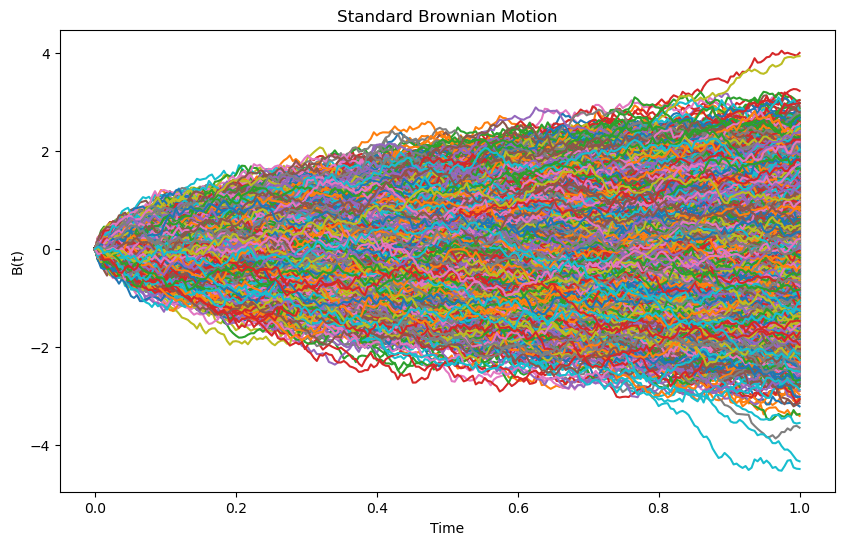

In [17]:
plt.figure(figsize=(10, 6))

for i in range(p):
    BM_all[i] = brownian_motion_path(random_number_vector[i], constant_time_gap)  # Store all paths
    plt.plot(time_vector, BM_all[i])  # Plot each pathplt.plot(t, mean_BM, color="red", linewidth=2, label="Mean of Brownian Motion")
plt.xlabel("Time")
plt.ylabel("B(t)")
plt.title("Standard Brownian Motion")
plt.show()

In [18]:
stock_return = total_drift_2023   # stock_mu
volatility = total_vol_2023 * 0.8   # sigma
mu = stock_return - (volatility ** 2)/2   # GBM mu
S0 = df.loc[249, 'Close']     #initial stock price

In [19]:
print(S0)

32.25


In [20]:
def GBM(random_numbers, time_gap, BM_path):
    S = np.zeros(len(random_numbers)) 
    log_returns_1 = np.zeros(len(random_numbers) - 1)
    S[0] = S0      
    for i in range(1, len(random_numbers)): 
        num_jumps = np.random.poisson(lambda_estimate_2023*0.35 * time_gap)
        if num_jumps > 0:
            jump_magnitude = np.sum(np.random.normal(mu_J_estimate*0.35, sigma_J_estimate*0.35, num_jumps))
        else:
            jump_magnitude = 0  # No jump
            
        S[i] = S[0] * np.exp(mu * time_gap*i + volatility * BM_path[i] + jump_magnitude)
        log_returns_1[i-1] = np.log(S[i] / S[i-1])
    return S,log_returns_1

In [47]:
A = []
for t in range(len(time_vector)):
    a = S0* np.exp((total_drift_2023 + lambda_estimate_2023*(np.exp(mu_J_estimate + 0.5*(sigma_J_estimate**0.5))-1))*(t*constant_time_gap ))
    A.append(a)
print(len(A))

236


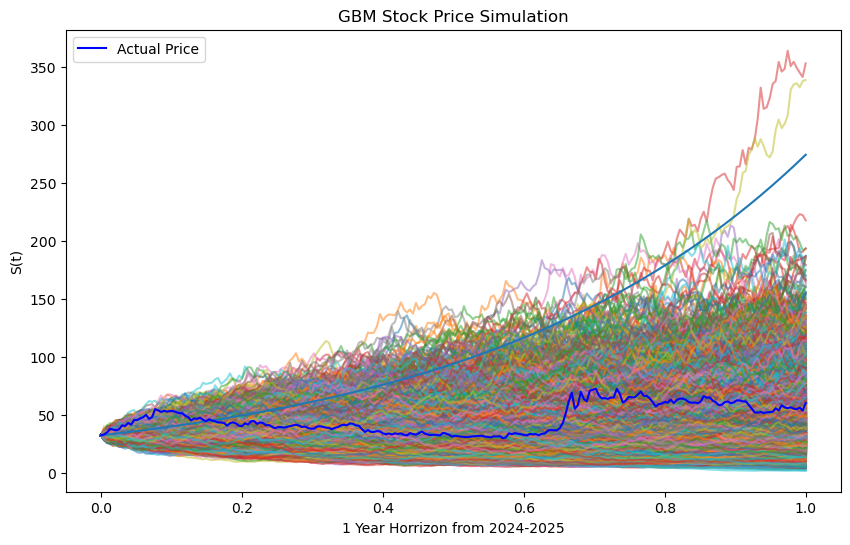

In [49]:
plt.figure(figsize=(10, 6))
simulated_final_price= np.zeros(p)  
simulated_log_returns = []

for i in range(p):
    Geometric_BM, log_returns_1 = GBM(random_number_vector[i], constant_time_gap, BM_all[i])  # Unpack correctly
    simulated_final_price[i] = Geometric_BM[-1]  # Take the last price
    simulated_log_returns.append(log_returns_1) # Store log returns
    plt.plot(time_vector, Geometric_BM, alpha=0.5)
    
plt.plot(time_vector, A)
    
 # Calculate and print the mean of the GBM simulation across all paths
plt.plot(time_vector,df.loc[249::,'Close'],label = "Actual Price",color = "blue")
plt.xlabel("1 Year Horrizon from 2024-2025")
plt.ylabel("S(t)")
plt.title("GBM Stock Price Simulation")
plt.legend()
plt.show()

95% VaR (Trading): 10.7 RMB
99% VaR (Trading): 7.12 RMB


C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


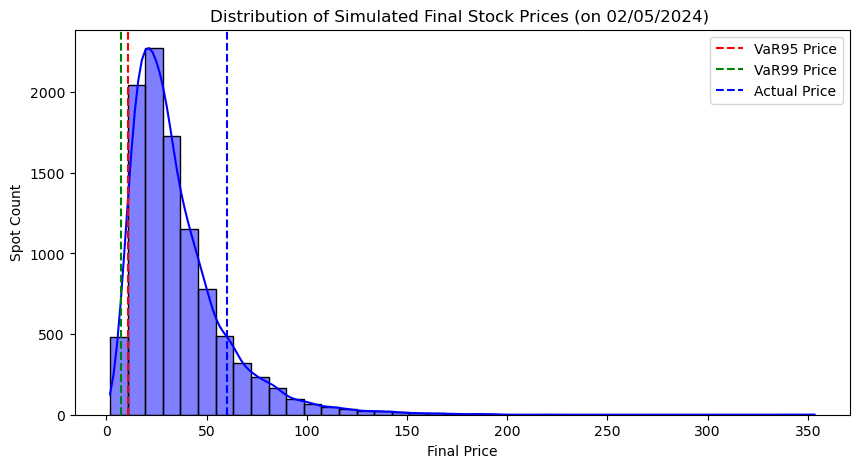

In [22]:
VaR_95_final_price = np.percentile(simulated_final_price , 5)  # 5th percentile for 95% confidence level
VaR_99_final_price = np.percentile(simulated_final_price , 1)  # 1st percentile for 99% confidence level
print(f"95% VaR (Trading): {VaR_95_final_price:.3} RMB")
print(f"99% VaR (Trading): {VaR_99_final_price:.3} RMB")
actual_price_final = df.iloc[-1]['Close']
plt.figure(figsize=(10, 5))
sns.histplot(simulated_final_price, bins=40, kde=True, color="blue", alpha=0.5)
plt.axvline(VaR_95_final_price, color="red", linestyle="dashed",label="VaR95 Price")
plt.axvline(VaR_99_final_price, color="green", linestyle="dashed",label="VaR99 Price")
plt.axvline(actual_price_final, color="blue", linestyle="dashed",label="Actual Price")
plt.xlabel("Final Price")
plt.ylabel("Spot Count")
plt.title("Distribution of Simulated Final Stock Prices (on 02/05/2024) ")
plt.legend()
plt.show()

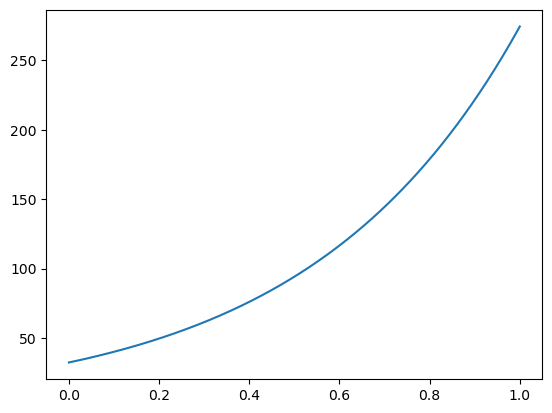

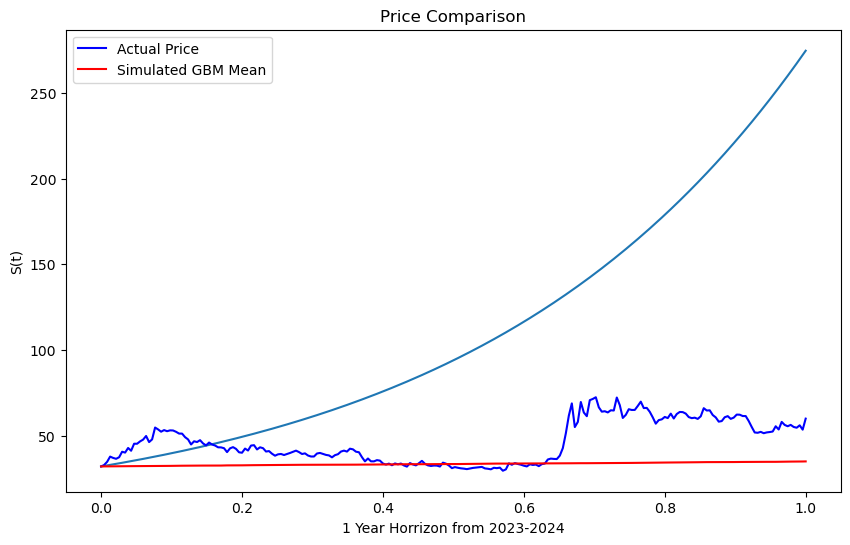

In [48]:
GBM_mean = np.mean([GBM(random_number_vector[i], constant_time_gap, BM_all[i])[0] for i in range(p)], axis=0)

plt.plot(time_vector, A)
    
plt.figure(figsize=(10, 6))
plt.plot(time_vector, A)
plt.plot(time_vector,df.loc[249::,'Close'],label = 'Actual Price',color = "blue")
plt.plot(time_vector, GBM_mean,label ='Simulated GBM Mean', color = "red")
plt.xlabel("1 Year Horrizon from 2023-2024")
plt.ylabel("S(t)")
plt.title("Price Comparison")
plt.legend()
plt.show()

10000


95% VaR: -64.19%
99% VaR: -76.10%


C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


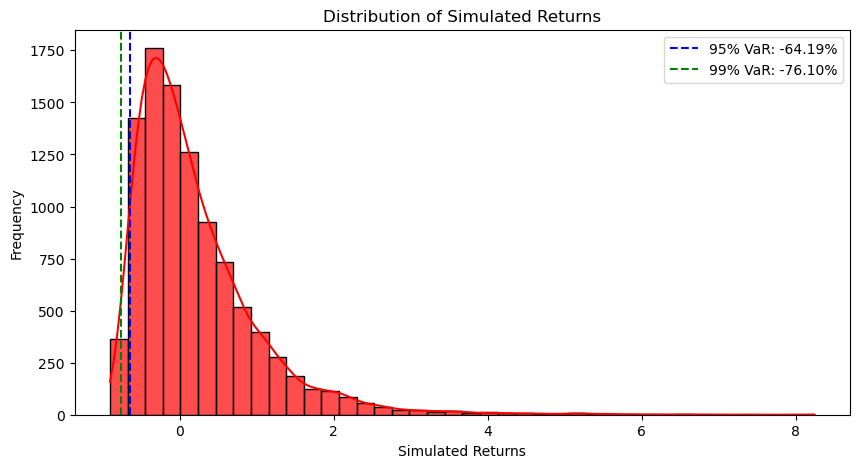

In [24]:
Geometric_BM_1 = np.zeros((p, len(time_vector)))
simulated_returns= np.zeros(p)  

for i in range(p):
    Geometric_BM_1[i] = GBM(random_number_vector[i], constant_time_gap, BM_all[i])[0]
    simulated_returns[i] = (Geometric_BM_1[i, -1] - S0) / S0 


VaR_95 = np.percentile(simulated_returns, 5)  # 5th percentile for 95% confidence level
VaR_99 = np.percentile(simulated_returns, 1)  # 1st percentile for 99% confidence level
print(f"95% VaR: {VaR_95:.2%}")
print(f"99% VaR: {VaR_99:.2%}")

plt.figure(figsize=(10, 5))
sns.histplot(simulated_returns, bins=40, kde=True, color="red", alpha=0.7)
plt.axvline(VaR_95, color="blue", linestyle="dashed", label=f"95% VaR: {VaR_95:.2%}")
plt.axvline(VaR_99, color="green", linestyle="dashed", label=f"99% VaR: {VaR_99:.2%}")
plt.xlabel("Simulated Returns")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated Returns")
plt.legend()
plt.show()

# Verify Model Accuracy

# Simulated Return v.s Actual

C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


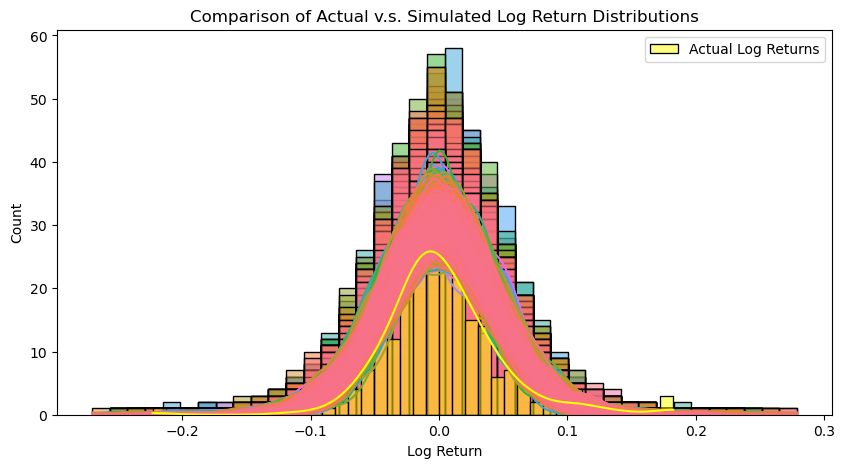

In [25]:
log_returns_2024 = np.log(df.loc[249:, 'Close']/ df.loc[249:, 'Close'].shift(1)).dropna()

plt.figure(figsize=(10, 5))

sns.histplot(simulated_log_returns, bins=40, kde=True, alpha=0.5)
sns.histplot(log_returns_2024, bins=40, kde=True, color="yellow", label="Actual Log Returns", alpha=0.5)


plt.xlabel("Log Return")
plt.ylabel("Count")
plt.title("Comparison of Actual v.s. Simulated Log Return Distributions")
plt.legend()
plt.show()


# KS Test

In [26]:
simulated_log_returns_flat = np.concatenate(simulated_log_returns)

ks_stat, p_value = ks_2samp(log_returns_2024, simulated_log_returns_flat)
print(f"KS Statistic: {ks_stat:.4f}, P-value: {p_value:.4f}")

if p_value > 0.05:
    print("Fail to reject null hypothesis: The distributions are similar.")
else:
    print("Reject null hypothesis: The distributions are different.")

KS Statistic: 0.0572, P-value: 0.4104
Fail to reject null hypothesis: The distributions are similar.


# Conclustion

The graph of 'Comparison of Actual v.s. Simulated Log Return Distributions' and KS Test indicates that the Jump Diffusion GBM model is fairly accurate and could be used for simulation purposes. 
The tuned jump diffusion parameters are lambda=lambda_estimate_2023 * 0.35, mu=mu_J_estimate * 0.35, sigma=sigma_J_estimate * 0.35
For the actual trading, we use lambda=lambda_estimate_2024 * 0.4, mu=mu_J_estimate_2024 * 0.4, sigma=sigma_J_estimate_2024 * 0.4 because it is in a bull period with more potential jumps.

# Jump Diffusion GBM Simulation for trading

In [27]:
trading_time_total_unit_2024 = df.loc[249::, 'Close'].count()

daily_drift_2024 = np.log(df.loc[249::,'daily_return']+1).sum() / trading_time_total_unit_2024
total_drift_2024 = daily_drift_2024 * trading_time_total_unit_2024
daily_vol_2024 = (((np.log(df.loc[249::,'daily_return']+1) - daily_drift_2024)**2).sum() / (trading_time_total_unit_2024 - 1)) ** 0.5
total_vol_2024 = daily_vol_2024 * ((trading_time_total_unit_2024) ** 0.5)
print(trading_time_total_unit_2024, total_drift_2024, total_vol_2024)


236 0.7024065059727419 0.7207351254335528


In [28]:
trading_days = 14
total_trading_days_2025 = 233
trading_time_total_unit_t = trading_days  # Total time frequency
T_t = trading_days   # Days intended to trade  
n_t = trading_time_total_unit_t # Gap Count
t_t = np.linspace(0,T_t,n_t)    # Time interval
B0_t = 0    # Initial stock price  

In [29]:
random_number_vector_t = np.array([np.random.normal(loc=0, scale=1,size = len(t_t)) for _ in range(p_t)])

In [30]:
time_vector_t = t_t

In [31]:
BM_all_t = np.zeros((p_t, n_t))  

In [32]:
mu_r_2024 = np.mean(log_returns_2024)
sigma_r_2024 = np.std(log_returns_2024)

# Define threshold for jumps (3 standard deviations from mean)
threshold_2024 = mu_r_2024 + 3 * sigma_r_2024

# Count jump occurrences
jump_days_2024 = np.sum((log_returns_2024 > threshold_2024) | (log_returns_2024 < -threshold_2024))

num_years_2024 = len(log_returns_2024) / (trading_time_total_unit_2024-1) 
lambda_estimate_2024 = jump_days_2024 / num_years_2024
print(num_years_2024)
print(f"Estimated Jump Intensity (lambda): {lambda_estimate_2024:.2f} jumps per year in 2024")

1.0
Estimated Jump Intensity (lambda): 4.00 jumps per year in 2024


In [33]:
jump_returns_2024 = log_returns_2024[(log_returns_2024 > threshold_2024) | (log_returns_2024 < -threshold_2024)]
mu_J_estimate_2024 = np.mean(jump_returns_2024)
sigma_J_estimate_2024 = np.std(jump_returns_2024)
print("Jump Returns:", jump_returns_2024)
print(f"Estimated Mean Jump Size (mu_J_2024): {mu_J_estimate_2024:.4f}")
print(f"Estimated Jump Volatility (sigma_J_2024): {sigma_J_estimate_2024:.4f}")

Jump Returns: 405    0.182399
406    0.182257
408   -0.223144
410    0.182264
Name: Close, dtype: float64
Estimated Mean Jump Size (mu_J_2024): 0.0809
Estimated Jump Volatility (sigma_J_2024): 0.1756


In [34]:
def brownian_motion_path_t(random_numbers, time_gap):
    B_t = np.zeros(len(random_numbers))
    B_t[0] = B0_t
    for i in range(1,len(random_numbers)):
        B_t[i] = B_t[i-1]+(time_gap ** 0.5) * random_numbers[i-1]
    return B_t

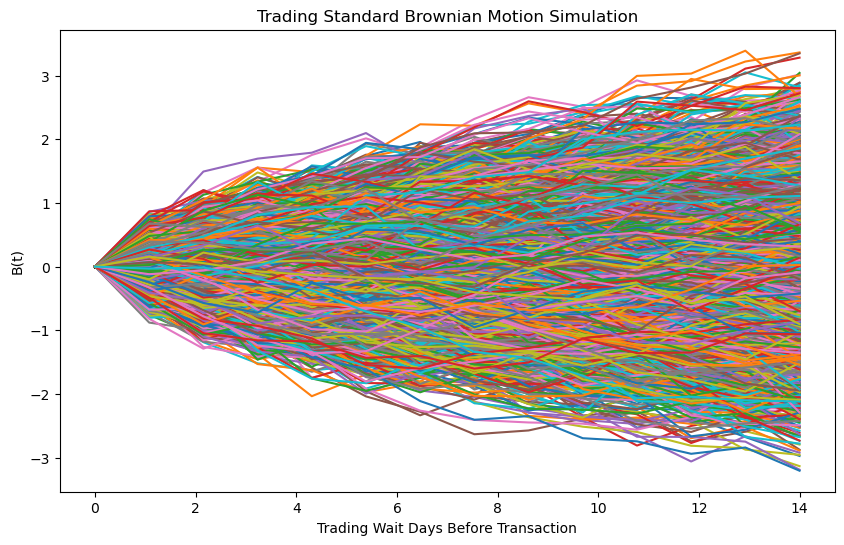

In [35]:
plt.figure(figsize=(10, 6))

for i in range(p_t):
    BM_all_t[i] = brownian_motion_path_t(random_number_vector_t[i], trading_days/ total_trading_days_2025)  # Store all paths
    plt.plot(time_vector_t, BM_all_t[i]) 
plt.xlabel("Trading Wait Days Before Transaction")
plt.ylabel("B(t)")
plt.title("Trading Standard Brownian Motion Simulation")
plt.show()

In [36]:
stock_return_t = total_drift_2024   # stock_mu
volatility_t = total_vol_2024*0.8   # sigma
mu_t = stock_return_t - (volatility_t ** 2)/2   # GBM mu
holding_price = 71.64
S0_t = holding_price  #initial stock price

In [37]:
def GBM_t(random_numbers, time_gap, BM_path):
    S_t = np.zeros(len(random_numbers)) 
    log_returns_t = np.zeros(len(random_numbers) - 1)
    S_t[0] = S0_t      
    for i in range(1, len(random_numbers)):
        num_jumps_2024 = np.random.poisson(((lambda_estimate_2024*0.4 * trading_days)/total_trading_days_2025) * time_gap)
        if num_jumps_2024 > 0:
            jump_magnitude_2024 = np.sum(np.random.normal(mu_J_estimate_2024*0.4, sigma_J_estimate_2024*0.4, num_jumps_2024))
        else:
            jump_magnitude_2024 = 0  # No jump
        S_t[i] = S_t[0] * np.exp(mu_t * time_gap + volatility_t * BM_path[i-1] + jump_magnitude_2024)
        log_returns_t[i-1] = np.log(S_t[i] / S_t[i-1])
    
    return S_t,log_returns_t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


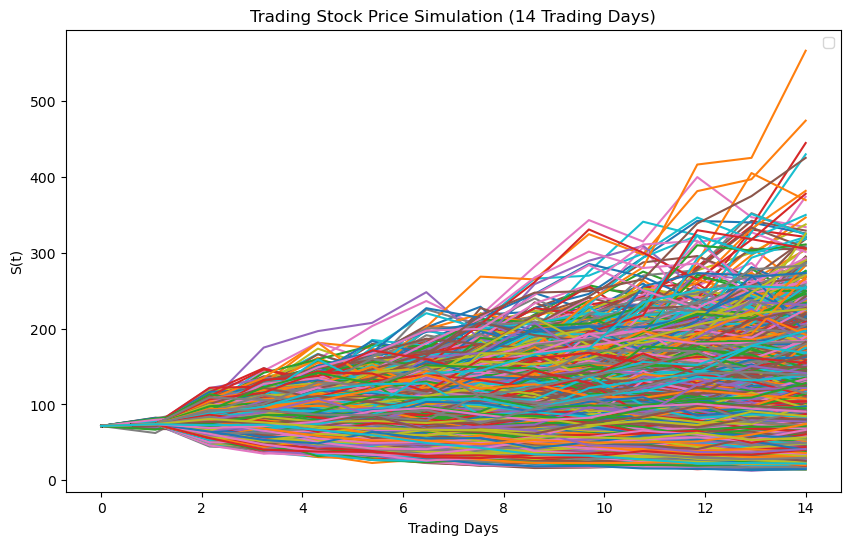

In [46]:
plt.figure(figsize=(10, 6))
simulated_final_price_t= np.zeros(p_t)
simulated_log_returns_t = []
for i in range(p_t):
    Geometric_BM_t, log_returns_t = GBM_t(random_number_vector_t[i], trading_days/ total_trading_days_2025, BM_all_t[i])
    simulated_final_price_t[i] = Geometric_BM_t[-1]
    simulated_log_returns_t.append(log_returns_t)
    plt.plot(time_vector_t, Geometric_BM_t)

plt.xlabel("Trading Days")
plt.ylabel("S(t)")
plt.title("Trading Stock Price Simulation (14 Trading Days)")
plt.legend()
plt.show()


In [39]:
a = [GBM_t(random_number_vector_t[i], trading_days/ total_trading_days_2025, BM_all_t[i])[0] for i in range(p_t)]
print(len(a))

10000


# Application

# 1. Expected Future Price Trends

📌If the mean price trends higher, bullish signal 📈 → Consider long positions.  
If the mean price trends lower, bearish signal 📉 → Consider shorting or hedging.  
Wide confidence intervals → High uncertainty → Use risk management strategies.

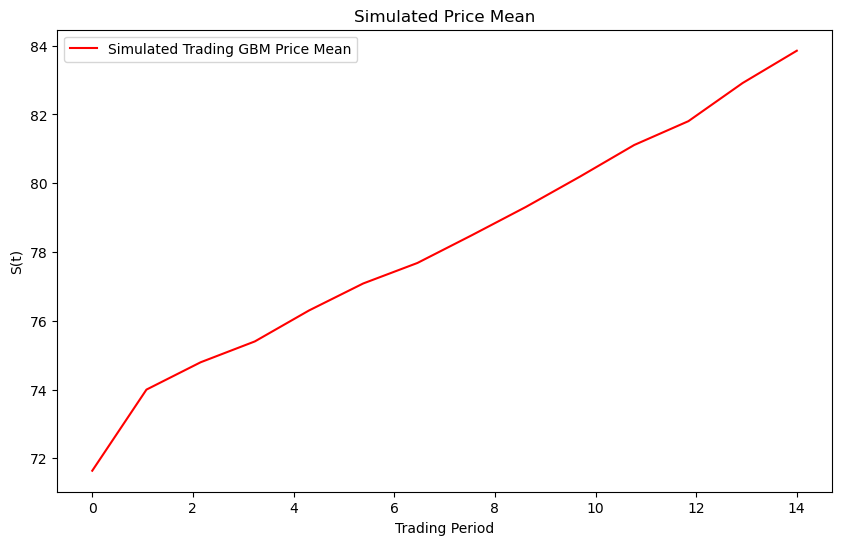

In [40]:
GBM_mean_t = np.mean([GBM_t(random_number_vector_t[i], trading_days/ total_trading_days_2025, BM_all_t[i])[0] for i in range(p_t)], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(time_vector_t, GBM_mean_t,label ='Simulated Trading GBM Price Mean', color = "red")
plt.xlabel("Trading Period")
plt.ylabel("S(t)")
plt.title("Simulated Price Mean")
plt.legend()
plt.show()

95% VaR (Trading): 33.3 RMB
99% VaR (Trading): 24.1 RMB


C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


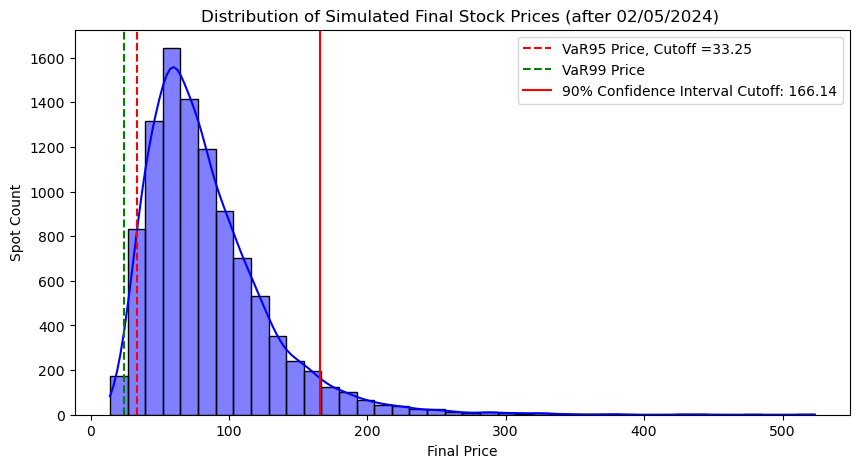

In [41]:
VaR_95_final_price_t = np.percentile(simulated_final_price_t , 5)  # 5th percentile for 95% confidence level
VaR_99_final_price_t = np.percentile(simulated_final_price_t , 1)  # 1st percentile for 99% confidence level
CF_90_Cutoff_t = np.percentile(simulated_final_price_t , 95)
print(f"95% VaR (Trading): {VaR_95_final_price_t:.3} RMB")
print(f"99% VaR (Trading): {VaR_99_final_price_t:.3} RMB")
plt.figure(figsize=(10, 5))
sns.histplot(simulated_final_price_t, bins=40, kde=True, color="blue", alpha=0.5)
plt.axvline(VaR_95_final_price_t, color="red", linestyle="dashed",label=f"VaR95 Price, Cutoff ={VaR_95_final_price_t:.2f}")
plt.axvline(VaR_99_final_price_t, color="green", linestyle="dashed",label="VaR99 Price")
plt.axvline(np.percentile(simulated_final_price_t , 95), color="red",label=f"90% Confidence Interval Cutoff: {CF_90_Cutoff_t:.2f}")
plt.xlabel("Final Price")
plt.ylabel("Spot Count")
plt.title("Distribution of Simulated Final Stock Prices (after 02/05/2024) ")
plt.legend()
plt.show()

# 2. Compute VaR (Risk of Loss)

📌If VaR is high, implement hedging strategies (protective puts, stop-loss orders).  
If VaR is low, the stock is relatively stable, so a larger allocation may be justified.

95% VaR (Trading): -53.59%
99% VaR (Trading): -66.40%


C:\Users\19874\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


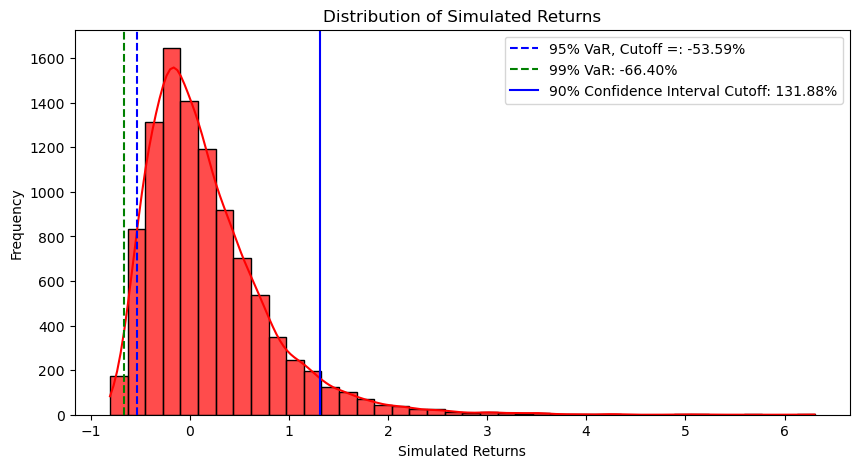

In [42]:
Geometric_BM_t_1 = np.zeros((p_t, len(time_vector_t))) 
simulated_returns_t = np.zeros(p_t)  
for i in range(p_t):
    Geometric_BM_t_1[i] = GBM_t(random_number_vector_t[i], trading_days/ total_trading_days_2025, BM_all_t[i])[0]
    simulated_returns_t[i] = (Geometric_BM_t_1[i, -1] - S0_t) / S0_t


VaR_95_t = np.percentile(simulated_returns_t, 5)  # 5th percentile for 95% confidence level
VaR_99_t = np.percentile(simulated_returns_t, 1)  # 1st percentile for 99% confidence level
CF_90_Cutoff_tr = np.percentile(simulated_returns_t, 95)
print(f"95% VaR (Trading): {VaR_95_t:.2%}")
print(f"99% VaR (Trading): {VaR_99_t:.2%}")

plt.figure(figsize=(10, 5))
sns.histplot(simulated_returns_t, bins=40, kde=True, color="red", alpha=0.7)
plt.axvline(VaR_95_t, color="blue", linestyle="dashed", label=f"95% VaR, Cutoff =: {VaR_95_t:.2%}")
plt.axvline(VaR_99_t, color="green", linestyle="dashed", label=f"99% VaR: {VaR_99_t:.2%}")
plt.axvline(CF_90_Cutoff_tr, color="blue", label=f"90% Confidence Interval Cutoff: {CF_90_Cutoff_tr:.2%}")
plt.xlabel("Simulated Returns") 
plt.ylabel("Frequency")
plt.title("Distribution of Simulated Returns")
plt.legend()
plt.show()

# 3. Assess Risk (Volatility)

📌If volatility is high, but price is trending up, consider options strategies (covered calls).  
If volatility is low, a long-term directional position (buy-and-hold) may be ideal.

In [43]:
simulated_log_returns_t_flat = np.concatenate(simulated_log_returns_t)
simulated_volatility_t = np.std(simulated_log_returns_t_flat)
print(f"Simulated Volatility: {simulated_volatility_t:.4f}")

Simulated Volatility: 0.1363


Comment: the 14 day vol of the daily log return is relatively low, but now, DeepSeek has positive news causing the price to increase drastically. When the price of an asset skyrockets (experiences a sharp upward movement), it is possible to observe high daily log returns with low volatility.

# 4. Detect Tail Risk (Extreme Losses)

📌 Portfolio Insight:  
Skew < 0 → More downside risk → Reduce position size or hedge.  
Kurtosis > 3 → Fat tails (more extreme moves) → Use tail-risk hedging (deep OTM options).

In [44]:
print(f"Skewness: {skew(simulated_log_returns_t_flat):.4f}")  
print(f"Kurtosis: {kurtosis(simulated_log_returns_t_flat, fisher=True):.4f}") 

Skewness: -0.0646
Kurtosis: 0.2140


# 5. Portfolio Allocation Strategy

📌 Portfolio Insight:  
Annualized Sharpe Ratio > 1 → Good risk-adjusted return → Consider larger allocation.  
Annualized Sharpe Ratio < 0.5 → Low risk-adjusted return → Diversification is needed.

In [45]:
risk_free_rate = 0.0162
expected_return = np.mean(simulated_log_returns_t_flat)
daily_sharpe_ratio = (expected_return - (risk_free_rate / total_trading_days_2025)) / simulated_volatility_t
annualized_return = expected_return * total_trading_days_2025
annualized_volatility = simulated_volatility_t * total_trading_days_2025
annualized_sharpe_ratio = daily_sharpe_ratio * (total_trading_days_2025 ** 0.5)

print(f"Expected Daily Return: {expected_return:.2%}")
print(f"Daily Volatility: {simulated_volatility_t:.2f}")
print(f"Daily Sharpe Ratio: {daily_sharpe_ratio:.2f}")
print(f"Expected Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")

Expected Daily Return: 0.28%
Daily Volatility: 0.14
Daily Sharpe Ratio: 0.02
Expected Annualized Return: 65.57%
Annualized Volatility: 31.76
Annualized Sharpe Ratio: 0.31
